In [1]:
# Quietly compile autovarlamba.f90
import os
import sys
# os.system("f2py -c -m autovarlambda SR.read_write_as.for f2py_autovarlambda.f90 --quiet")
# print("\n===>>> autovarlambda compiled with f2py <<<===")

# Import other stuff
import numpy as np
import autovarlambda
import time
import pandas as pd
import yaml
import GPy
import GPyOpt
from numpy.random import seed
seed(123456)


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec

colors=['k','r','g','b','m','y','c','tab:blue',
        'tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray']
orb=['1s','2s','2p','3s','3p','3d','4s','4p','4d','4f','5s','5p','5d','5f','5g']
symbs=['o','s','v','^','>','<','o','o','o','o','o','o','o','o','o']

In [2]:
# Input parameters
global gridtype, cfgs, maxevals, mtype, aftype, afweight, gridtype, igrid, initer, ipol
global nlamvar, maxlam, minlam, mfunc, ifun, minst, imin, nener, wi, igi

print("\n===>>> Input parameters <<<===\n")
with open("varlam_gpyopt.yml", 'r') as stream:
    data_loaded=yaml.load(stream)

cfgs=data_loaded.get("cfgs")
if cfgs is None: raise ValueError("Error: cfgs not defined.")

initer=data_loaded.get("initer")
if initer is None: raise ValueError("Error: initer not defined.")
print(" * initial evaluations: "+str(initer))

maxevals=data_loaded.get("maxevals")
if maxevals is None: raise ValueError("Error: maxevals not defined.")
print(" * evaluations: "+str(maxevals))

mtype=data_loaded.get("mtype")
if mtype=="GP": print(" * model type: "+mtype)
elif mtype is None: 
    mtype="GP"
    print("Warning: model type not defined. Use default: GP")
else: raise ValueError("Error: "+mtype+" not implemented.")

aftype=data_loaded.get("aftype")
if aftype=="EI" or aftype=="MPI" or aftype=="LCB": print(" * acquisition function type: "+aftype)
elif aftype is None: 
    aftype="EI"
    print("Warning: acquisition function type not defined. Use default: EI")
else: raise ValueError("Error: "+mtype+" not implemented.")

afweight=data_loaded.get("afweight")
if afweight: print(" * acquisition function weight: "+str(afweight))
elif afweight is None: 
    afweight=1.
    print("Warning: acquisition function weight not defined. Use default: 1.")

gridtype=data_loaded.get("gridtype")
if gridtype=="continuous":
    igrid=0
    print(" * grid type: "+gridtype)
elif gridtype is None: 
    igrid=0
    print("Warning: grid type not defined. Use default: continuous")
else: raise ValueError("Error: "+gridtype+" not implemented.")

nlamvar=data_loaded.get("nlamvar")
if nlamvar is None: raise ValueError("Error: nlamvar not defined.")

maxlam=data_loaded.get("maxlam")
minlam=data_loaded.get("minlam")
if maxlam is None or minlam is None: raise ValueError("Error: maxlam and/or minlam not defined.")

mfunc=data_loaded.get("mfunc")
if mfunc=="Er":
    ifun=0
    print(" * minimization function: sum of weighted relative errors")
elif mfunc=="Er**2":
    ifun=1
    print(" * minimization function: sum of weighted square relative errors")
elif mfunc is None: 
    imin=0
    print("Warning: minimization function not defined. Use default: Er ")
else: raise ValueError("Error: "+mfunc+" not implemented.")

minst=data_loaded.get("minst")
if minst=="gr+ex":
    imin=0
    print(" * states included in minimization: ground + excited")
elif minst=="ex":
    imin=1
    print(" * states included in minimization: excited")
elif minst is None: 
    ifun=0
    print("Warning: states to be minimized not defined. Use default: ground + excited")
else: raise ValueError("Error: "+minst+" not implemented.")

nener=data_loaded.get("nener")
if nener is None: raise ValueError("Error: nener not defined.")

wi=data_loaded.get("wi")
if wi=="eq" or wi=="gi":
    if wi=="eq": igi=0
    if wi=="gi": igi=1
    weight=np.full(nener,1.)
    print(" * weight type: "+wi)
elif wi=="inp":
    inpweight=data_loaded.get("weight")
    linpw=len(inpweight)
    if linpw<nener: # fill the missing wi with the last input value
        for i in range(linpw,nener):
            inpweight.append(inpweight[linpw-1])
    weight=np.array(listweight)
    if inpweight is None or linpw==0:
        raise ValueError("Error: weight not defined.")
elif wi is None:
    igi=1
    print("Warning: wi not defined. Use default: eq")
else: raise ValueError("Error: "+wi+"not implemented.")

vpol=data_loaded.get("vpol")
if vpol==True: 
    ipol=1
    autovarlambda.polbck.ipol=ipol
    print(" * include polarization ON.")
else:
    print(" * no polarization.")



===>>> Input parameters <<<===

 * initial evaluations: 100
 * evaluations: 90
 * model type: GP
 * acquisition function type: EI
 * acquisition function weight: 0.0001
 * grid type: continuous
 * minimization function: sum of weighted relative errors
 * states included in minimization: ground + excited
 * weight type: eq
 * include polarization ON.


In [3]:
# Define useful functions

def atom_name(nzion):
    nzion=abs(nzion)
    atomname=['H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg']
    nname=len(atomname)
    if nzion>nname: raise ValueError("atomname not defined for Z="+str(nzion))
    for i in range(nname):
        if nzion==i+1: chatom=atomname[i] 
    return chatom

def pot_type(nzion):
    if nzion < 0:
        chtype="STO"
    else:
        chtype="TFDA"
    return chtype

# Define function for writing iteration number in a human-readable-way
def human_format(num):
    magnitude=0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000
    return '%.f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

# Define functions to be used
def error_relat(valexact,valcomp):
    if valexact == 0.0 or valcomp == 0.0:
        error=999
    error=abs((valexact-valcomp)/valexact)*100
    return error

def loss_wsumE(enere,enerc,neex,weight):
    loss=0.0
    if igi==1: weight=autovarlambda.compbck.gic
    for i in range(imin,neex): # consider ground energy and/or-only excited states
        diff=error_relat(enere[i],enerc[i])
        if ifun==1: diff=diff*diff
        loss=loss + weight[i]*diff
    return loss

# Define the search space domain
def myspace(minlam,maxlam):
    space=[]
    for i in range(nlamvar):
        alam=str(i+1)
        space.append({'name': 'lam'+alam, 'type': gridtype, 'domain': (minlam,maxlam)})
    return space

def mypolspace(alfd_min,alfd_max,rcut_min,rcut_max):
    polspace=({'name': 'alfd','type': 'continuous', 'domain': (alfd_min,alfd_max)},
              {'name': 'rcut','type': 'continuous', 'domain': (rcut_min,rcut_max)})
    return polspace

def mykernel(rbf,stdperiodic):
    # define RBF kernel a.k.a. squared-exponential (SE)
#    if rbf==1: kernel=GPy.kern.RBF(input_dim=nlamvar,variance=varf,lengthscale=lf,ARD=ARD)
    if rbf==1: kernel=GPy.kern.RBF(input_dim=2,variance=varf,lengthscale=lf,ARD=ARD)
#    if rbf==1 and stdperiodic==1:
#        kernel1=GPy.kern.RBF(input_dim=nlamvar,variance=varf,lengthscale=lf,ARD=ARD)
#        # define a standard periodic kernel
#        kernel2=GPy.kern.StdPeriodic(input_dim=nlamvar,variance=varf,period=None,lengthscale=None,
#                                     ARD1=ARD,ARD2=ARD)
#        kernel=kernel1*kernel2
    return kernel

# Define function to be minimized
def var_lambda(x):
    minlam=0.1
    lam=x[0,:]
    autovarlambda.run_as(lam,nlamvar)
    neex=autovarlambda.exactbck.ne
    enere=autovarlambda.eneroutbck.enere
    enerc=autovarlambda.eneroutbck.enerc
    loss=loss_wsumE(enere,enerc,neex,weight)
    return loss

# Define function to be minimized
def var_pol(x):
    pol=x[0,:]
    print(pol)
    autovarlambda.run_as_pol(pol)
    neex=autovarlambda.exactbck.ne
    enere=autovarlambda.eneroutbck.enere
    enerc=autovarlambda.eneroutbck.enerc
    loss=loss_wsumE(enere,enerc,neex,weight)
    return loss

# Determine file name string vector from fortran subroutine data
def def_filename():
    global ncfg, filename
    ncfg=autovarlambda.salgebbck.mxconf
    nzion=autovarlambda.sminimbck.nzion
    chatom=atom_name(nzion)
    chtype=pot_type(nzion)
    cfgs=str(ncfg)+"CFG"+chtype
    filename=chatom+cfgs+"_"+mtype+human_format(maxevals)

# Open .out file
def open_fout():
    global fener
    fener=open(filename+".out","w")

# Define and initialize variables
def init_var():
    enere=np.zeros(nener)
    enerc=np.zeros(nener)
    neex=int()
    return enere, enerc, neex

# Print best results
def print_eresults(lam_best,nlamvar,filename,fener,total):
    autovarlambda.run_as(lam_best,nlamvar)
    neex=autovarlambda.eneroutbck.neex
    enere=autovarlambda.eneroutbck.enere
    enerc=autovarlambda.eneroutbck.enerc
    loss_best=loss_wsumE(enere,enerc,neex,weight)
    erroregr=error_relat(enere[0],enerc[0])
    print("\n Number of evaluations={:10d}".format(maxevals),file=fener)
    print("                  Time={:10.3f} min".format(total),file=fener)
    print("-"*80,file=fener)
    print(" Best results:",file=fener)
    print("-"*80,file=fener)
    print("\n  lambda={} ".format(lam_best[0]),file=fener)
    print("\n  Ground State Energy ={:12.6f}".format(enerc[0]),
          "\n                  NIST={:12.6f}".format(enere[0]),
          "\n                   Er%={:12.4f} %".format(erroregr),file=fener)
    for i in range(1,neex):
        errorex=error_relat(enere[i],enerc[i])
        print("\n       {} Excit. Energy={:12.6f}".format(i,enerc[i]),
              "\n                  NIST={:12.6f}".format(enere[i]),
              "\n                   Er%={:12.6f} %".format(errorex),file=fener)
    print("\n            Total loss={:12.4f} %".format(loss_best),file=fener)
    autovarlambda.print_ener()
    os.system("mv relat_error.dat "+filename+".erp")
    fener.close()


In [4]:
def run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi):
    iseed=initer*1000+maxevals*100+(initer*maxevals)*10
    seed(iseed)
    enere, enerc, neex=init_var()
    cpdas="cp das_" + str(cfgs) + "CFG das"
    os.system(cpdas)
    autovarlambda.open_files()
    autovarlambda.inp_das()
    autovarlambda.inp_exact()
    dummyne=autovarlambda.exactbck.ne.copy()
    if nener != dummyne:
        autovarlambda.exactbck.ne=nener
    def_filename()
    if ncfg != cfgs:
        print(" >>>> configuration mismatch !!!! ")
        sys.exit()
    open_fout()
    t0=time.time()
    model=GPyOpt.models.GPModel(kernel=kernel,noise_var=noise_var,exact_feval=exact_feval,
                                optimizer='lbfgs',optimize_restarts=optimize_restarts,
                                verbose=False,ARD=ARD)
    dspace=GPyOpt.Design_space(space=space)
    objective=GPyOpt.core.task.SingleObjective(var_pol)
    initial_design=GPyOpt.experiment_design.initial_design('random',dspace,initer)
    acquisition_optimizer=GPyOpt.optimization.AcquisitionOptimizer(dspace, optimizer='lbfgs')
    acquisition=GPyOpt.acquisitions.AcquisitionEI(model,dspace,acquisition_optimizer,jitter=xi)
    evaluator=GPyOpt.core.evaluators.Sequential(acquisition)
    myBopt=GPyOpt.methods.ModularBayesianOptimization(model,dspace,objective,acquisition,
                                                      evaluator,X_init=initial_design,normalize_Y=False)
    myBopt.run_optimization(maxevals,eps=1e-5,verbosity=False)
    myBopt.plot_acquisition()
    t1=time.time()
    total=(t1-t0)/60.
    print("\n Total time: "+str(total)+' min')
    pol_best=myBopt.x_opt
    pol_best=pol_best.reshape(-1,2)
    dimpol=len(pol_best)
    global fmin
    fmin=myBopt.fx_opt
    print(" pol_best=",pol_best[0])
    print(" fmin=",fmin)
    myBopt.save_evaluations(filename+".dat")

    autovarlambda.run_as_pol(pol_best)
    neex=autovarlambda.eneroutbck.neex
    enere=autovarlambda.eneroutbck.enere
    enerc=autovarlambda.eneroutbck.enerc
    loss_best=loss_wsumE(enere,enerc,neex,weight)
    erelat=[]
    erroregr=error_relat(enere[0],enerc[0])
    erelat.append(erroregr)
    print("\n Number of evaluations={:10d}".format(maxevals),file=fener)
    print("                  Time={:10.3f} min".format(total),file=fener)
    print("-"*80,file=fener)
    print(" Best results:",file=fener)
    print("-"*80,file=fener)
    print("\n  pol={} ".format(pol_best[0]),file=fener)
    print("\n  Ground State Energy ={:12.6f}".format(enerc[0]),
          "\n                  NIST={:12.6f}".format(enere[0]),
          "\n                   Er%={:12.4f} %".format(erroregr),file=fener)
    for i in range(1,neex):
        errorex=error_relat(enere[i],enerc[i])
        erelat.append(errorex)
        print("\n       {} Excit. Energy={:12.6f}".format(i,enerc[i]),
              "\n                  NIST={:12.6f}".format(enere[i]),
              "\n                   Er%={:12.6f} %".format(errorex),file=fener)
    print("\n            Total loss={:12.4f} %".format(loss_best),file=fener)
    autovarlambda.print_ener()
    os.system("mv relat_error.dat "+filename+".erp")
    os.system("mv tmp "+filename+".das")
    fener.close()

    return pol_best[0],erelat

In [10]:
help(GPyOpt.models.GPModel)

Help on class GPModel in module GPyOpt.models.gpmodel:

class GPModel(GPyOpt.models.base.BOModel)
 |  GPModel(kernel=None, noise_var=None, exact_feval=False, optimizer='bfgs', max_iters=1000, optimize_restarts=5, sparse=False, num_inducing=10, verbose=True, ARD=False)
 |  
 |  General class for handling a Gaussian Process in GPyOpt.
 |  
 |  :param kernel: GPy kernel to use in the GP model.
 |  :param noise_var: value of the noise variance if known.
 |  :param exact_feval: whether noiseless evaluations are available. IMPORTANT to make the optimization work well in noiseless scenarios (default, False).
 |  :param optimizer: optimizer of the model. Check GPy for details.
 |  :param max_iters: maximum number of iterations used to optimize the parameters of the model.
 |  :param optimize_restarts: number of restarts in the optimization.
 |  :param sparse: whether to use a sparse GP (default, False). This is useful when many observations are available.
 |  :param num_inducing: number of ind

[0.03629561 0.56961564]
[0.02272967 0.79332285]
[0.0130195  0.55678817]
[0.01455689 0.51401655]
[0.06303518 0.63596379]
[0.06211849 0.58050779]
[0.01679914 0.5310144 ]
[0.0229862  0.53098922]
[0.03902978 0.56844831]
[0.03667882 0.70888917]
[0.04787997 0.75213645]
[0.02269615 0.5108548 ]
[0.01203315 0.78089487]
[0.0336003  0.62514029]
[0.04763975 0.70640339]
[0.04047581 0.68424836]
[0.01673948 0.69867057]
[0.01862886 0.71805337]
[0.02892595 0.56546936]
[0.04934127 0.79486506]
[0.05753993 0.53879367]
[0.05534778 0.607308  ]
[0.04522093 0.68894644]
[0.05781495 0.55660597]
[0.04053653 0.73151196]
[0.03131276 0.75219594]
[0.03621078 0.6133803 ]
[0.06622337 0.66130659]
[0.06055703 0.61836479]
[0.03907764 0.66702807]
[0.04481557 0.70161969]
[0.03853339 0.69457916]
[0.01101307 0.5266281 ]
[0.0379502  0.68126429]
[0.04704717 0.63896945]
[0.0464606  0.78293922]
[0.0649526  0.79254497]
[0.05347194 0.60120768]
[0.03299978 0.68439629]
[0.04896874 0.7019191 ]
[0.03865838 0.75483517]
[0.0223626  0.68

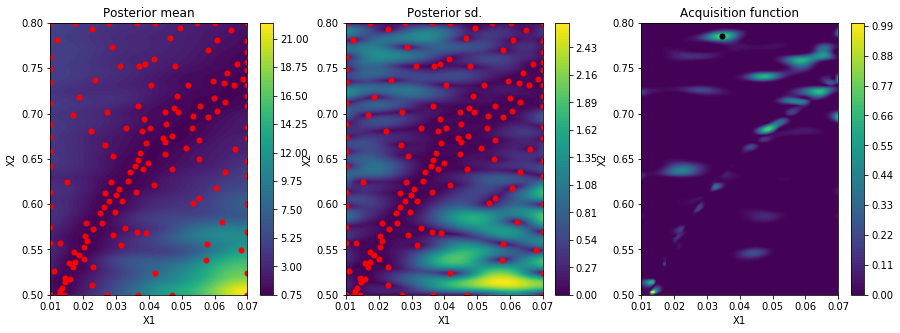


 Total time: 4.3233211477597555 min
 pol_best= [0.01283615 0.50372218]
 fmin= 0.8780559864470625
0.07227420608132704
0.07438723234634441
0.185692079173719
0.020991406100462247
0.03259898483174241
0.3703283552266329
0.0004864570175326548
0.07735658720069592
0.0373226501105965
0.006618028358009442
mean error= 0.08780559864470625


In [5]:
noise_var=None
exact_feval=True
ARD=True
varf=2.5
lf=0.1
xi=0.0001
optimize_restarts=5


initer=50
maxevals=100
nener=10


alfd_min=0.01
alfd_max=0.07
rcut_min=0.5
rcut_max=0.8
space=mypolspace(alfd_min,alfd_max,rcut_min,rcut_max)
kernel=mykernel(rbf=1,stdperiodic=0)
pol_best,erelat=run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)
for i in erelat:
    print(i)
print('mean error=',sum(erelat)/len(erelat))

[0.03629561 0.56961564]
[0.02272967 0.79332285]
[0.0130195  0.55678817]
[0.01455689 0.51401655]
[0.06303518 0.63596379]
[0.06211849 0.58050779]
[0.01679914 0.5310144 ]
[0.0229862  0.53098922]
[0.03902978 0.56844831]
[0.03667882 0.70888917]
[0.04787997 0.75213645]
[0.02269615 0.5108548 ]
[0.01203315 0.78089487]
[0.0336003  0.62514029]
[0.04763975 0.70640339]
[0.04047581 0.68424836]
[0.01673948 0.69867057]
[0.01862886 0.71805337]
[0.02892595 0.56546936]
[0.04934127 0.79486506]
[0.05753993 0.53879367]
[0.05534778 0.607308  ]
[0.04522093 0.68894644]
[0.05781495 0.55660597]
[0.04053653 0.73151196]
[0.03131276 0.75219594]
[0.03621078 0.6133803 ]
[0.06622337 0.66130659]
[0.06055703 0.61836479]
[0.03907764 0.66702807]
[0.04481557 0.70161969]
[0.03853339 0.69457916]
[0.01101307 0.5266281 ]
[0.0379502  0.68126429]
[0.04704717 0.63896945]
[0.0464606  0.78293922]
[0.0649526  0.79254497]
[0.05347194 0.60120768]
[0.03299978 0.68439629]
[0.04896874 0.7019191 ]
[0.03865838 0.75483517]
[0.0223626  0.68

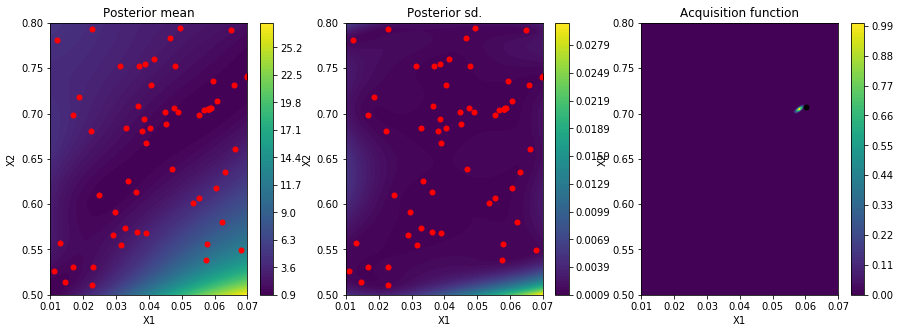


 Total time: 0.3648639440536499 min
 pol_best= [0.01679914 0.5310144 ]
 fmin= 0.8892551423043568
0.09851762034440552
0.10148031721532547
0.15939065252686874
0.004280325998826151
0.007199024838494398
0.3432693791646552
0.02599680468224965
0.10569344023350619
0.011607446308812924
0.03182013099121266
mean error= 0.08892551423043568


In [6]:
noise_var=None
exact_feval=True
ARD=True
varf=2.5
lf=0.1
xi=0.0001
optimize_restarts=0


initer=50
maxevals=100
nener=10


alfd_min=0.01
alfd_max=0.07
rcut_min=0.5
rcut_max=0.8
space=mypolspace(alfd_min,alfd_max,rcut_min,rcut_max)
kernel=mykernel(rbf=1,stdperiodic=0)
pol_best,erelat=run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)
for i in erelat:
    print(i)
print('mean error=',sum(erelat)/len(erelat))

[0.03629561 0.56961564]
[0.02272967 0.79332285]
[0.0130195  0.55678817]
[0.01455689 0.51401655]
[0.06303518 0.63596379]
[0.06211849 0.58050779]
[0.01679914 0.5310144 ]
[0.0229862  0.53098922]
[0.03902978 0.56844831]
[0.03667882 0.70888917]
[0.04787997 0.75213645]
[0.02269615 0.5108548 ]
[0.01203315 0.78089487]
[0.0336003  0.62514029]
[0.04763975 0.70640339]
[0.04047581 0.68424836]
[0.01673948 0.69867057]
[0.01862886 0.71805337]
[0.02892595 0.56546936]
[0.04934127 0.79486506]
[0.05753993 0.53879367]
[0.05534778 0.607308  ]
[0.04522093 0.68894644]
[0.05781495 0.55660597]
[0.04053653 0.73151196]
[0.03131276 0.75219594]
[0.03621078 0.6133803 ]
[0.06622337 0.66130659]
[0.06055703 0.61836479]
[0.03907764 0.66702807]
[0.04481557 0.70161969]
[0.03853339 0.69457916]
[0.01101307 0.5266281 ]
[0.0379502  0.68126429]
[0.04704717 0.63896945]
[0.0464606  0.78293922]
[0.0649526  0.79254497]
[0.05347194 0.60120768]
[0.03299978 0.68439629]
[0.04896874 0.7019191 ]
[0.03865838 0.75483517]
[0.0223626  0.68

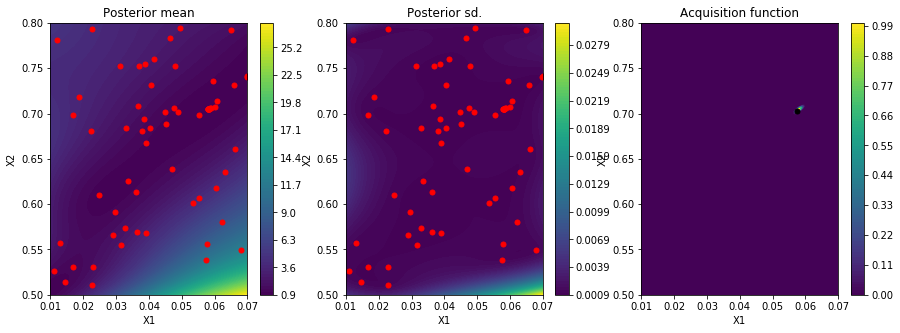


 Total time: 0.38086583216985065 min
 pol_best= [0.01679914 0.5310144 ]
 fmin= 0.8892551423043568
0.09851762034440552
0.10148031721532547
0.15939065252686874
0.004280325998826151
0.007199024838494398
0.3432693791646552
0.02599680468224965
0.10569344023350619
0.011607446308812924
0.03182013099121266
mean error= 0.08892551423043568


In [7]:
noise_var=None
exact_feval=True
ARD=False
varf=2.5
lf=0.1
xi=0.0001
optimize_restarts=0


initer=50
maxevals=100
nener=10


alfd_min=0.01
alfd_max=0.07
rcut_min=0.5
rcut_max=0.8
space=mypolspace(alfd_min,alfd_max,rcut_min,rcut_max)
kernel=mykernel(rbf=1,stdperiodic=0)
pol_best,erelat=run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)
for i in erelat:
    print(i)
print('mean error=',sum(erelat)/len(erelat))

[0.03629561 0.56961564]
[0.02272967 0.79332285]
[0.0130195  0.55678817]
[0.01455689 0.51401655]
[0.06303518 0.63596379]
[0.06211849 0.58050779]
[0.01679914 0.5310144 ]
[0.0229862  0.53098922]
[0.03902978 0.56844831]
[0.03667882 0.70888917]
[0.04787997 0.75213645]
[0.02269615 0.5108548 ]
[0.01203315 0.78089487]
[0.0336003  0.62514029]
[0.04763975 0.70640339]
[0.04047581 0.68424836]
[0.01673948 0.69867057]
[0.01862886 0.71805337]
[0.02892595 0.56546936]
[0.04934127 0.79486506]
[0.05753993 0.53879367]
[0.05534778 0.607308  ]
[0.04522093 0.68894644]
[0.05781495 0.55660597]
[0.04053653 0.73151196]
[0.03131276 0.75219594]
[0.03621078 0.6133803 ]
[0.06622337 0.66130659]
[0.06055703 0.61836479]
[0.03907764 0.66702807]
[0.04481557 0.70161969]
[0.03853339 0.69457916]
[0.01101307 0.5266281 ]
[0.0379502  0.68126429]
[0.04704717 0.63896945]
[0.0464606  0.78293922]
[0.0649526  0.79254497]
[0.05347194 0.60120768]
[0.03299978 0.68439629]
[0.04896874 0.7019191 ]
[0.03865838 0.75483517]
[0.0223626  0.68

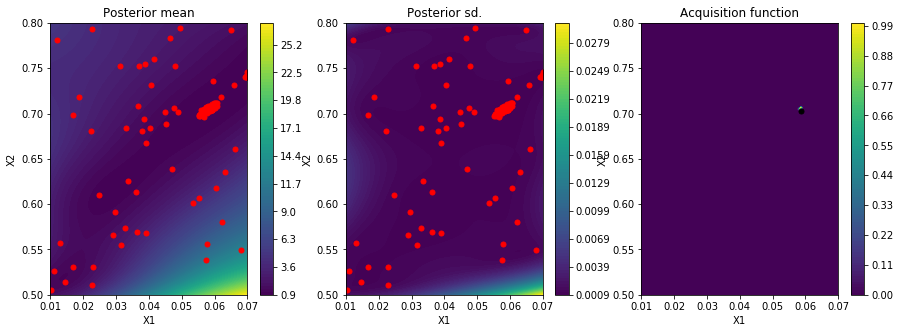


 Total time: 0.7900823712348938 min
 pol_best= [0.01679914 0.5310144 ]
 fmin= 0.8892551423043568
0.09851762034440552
0.10148031721532547
0.15939065252686874
0.004280325998826151
0.007199024838494398
0.3432693791646552
0.02599680468224965
0.10569344023350619
0.011607446308812924
0.03182013099121266
mean error= 0.08892551423043568


In [8]:
noise_var=None
exact_feval=True
ARD=False
varf=2.5
lf=0.1
xi=0.01
optimize_restarts=0


initer=50
maxevals=100
nener=10


alfd_min=0.01
alfd_max=0.07
rcut_min=0.5
rcut_max=0.8
space=mypolspace(alfd_min,alfd_max,rcut_min,rcut_max)
kernel=mykernel(rbf=1,stdperiodic=0)
pol_best,erelat=run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)
for i in erelat:
    print(i)
print('mean error=',sum(erelat)/len(erelat))

[0.03629561 0.56961564]
[0.02272967 0.79332285]
[0.0130195  0.55678817]
[0.01455689 0.51401655]
[0.06303518 0.63596379]
[0.06211849 0.58050779]
[0.01679914 0.5310144 ]
[0.0229862  0.53098922]
[0.03902978 0.56844831]
[0.03667882 0.70888917]
[0.04787997 0.75213645]
[0.02269615 0.5108548 ]
[0.01203315 0.78089487]
[0.0336003  0.62514029]
[0.04763975 0.70640339]
[0.04047581 0.68424836]
[0.01673948 0.69867057]
[0.01862886 0.71805337]
[0.02892595 0.56546936]
[0.04934127 0.79486506]
[0.05753993 0.53879367]
[0.05534778 0.607308  ]
[0.04522093 0.68894644]
[0.05781495 0.55660597]
[0.04053653 0.73151196]
[0.03131276 0.75219594]
[0.03621078 0.6133803 ]
[0.06622337 0.66130659]
[0.06055703 0.61836479]
[0.03907764 0.66702807]
[0.04481557 0.70161969]
[0.03853339 0.69457916]
[0.01101307 0.5266281 ]
[0.0379502  0.68126429]
[0.04704717 0.63896945]
[0.0464606  0.78293922]
[0.0649526  0.79254497]
[0.05347194 0.60120768]
[0.03299978 0.68439629]
[0.04896874 0.7019191 ]
[0.03865838 0.75483517]
[0.0223626  0.68

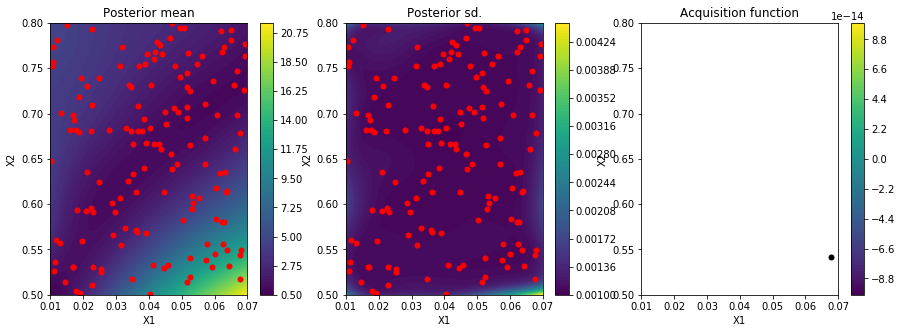


 Total time: 0.7399533669153849 min
 pol_best= [0.01679914 0.5310144 ]
 fmin= 0.8892551423043568
0.09851762034440552
0.10148031721532547
0.15939065252686874
0.004280325998826151
0.007199024838494398
0.3432693791646552
0.02599680468224965
0.10569344023350619
0.011607446308812924
0.03182013099121266
mean error= 0.08892551423043568


In [9]:
noise_var=None
exact_feval=True
ARD=False
varf=2.5
lf=0.1
xi=1.
optimize_restarts=0


initer=50
maxevals=100
nener=10


alfd_min=0.01
alfd_max=0.07
rcut_min=0.5
rcut_max=0.8
space=mypolspace(alfd_min,alfd_max,rcut_min,rcut_max)
kernel=mykernel(rbf=1,stdperiodic=0)
pol_best,erelat=run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)
for i in erelat:
    print(i)
print('mean error=',sum(erelat)/len(erelat))